In [1]:
import h2o

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 19.0.2+7-44, mixed mode, sharing)
  Starting server from C:\Users\Farzad\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Farzad\AppData\Local\Temp\tmp66trxefi
  JVM stdout: C:\Users\Farzad\AppData\Local\Temp\tmp66trxefi\h2o_Farzad_started_from_python.out
  JVM stderr: C:\Users\Farzad\AppData\Local\Temp\tmp66trxefi\h2o_Farzad_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,"21 days, 20 hours and 43 minutes"
H2O_cluster_name:,H2O_from_python_Farzad_eowqth
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.844 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [3]:
train_h2o = h2o.import_file('train_v1.csv')
train_h2o['Anomaly'] = train_h2o['Anomaly'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
test_h2o = h2o.import_file('test_v1.csv')
test_h2o['Anomaly'] = test_h2o['Anomaly'].asfactor()
test_h2o = test_h2o.na_omit()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
predictors = train_h2o.drop(['Anomaly','Index'], axis=1).columns
response = 'Anomaly'

In [6]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch


In [7]:
hyper_parameters = {
    'ntrees': [250, 500,1000,750]
}

In [8]:
rf_base_model = H2ORandomForestEstimator(seed=1,mtries=5,max_depth=None)
grid_search = H2OGridSearch(model=rf_base_model,
                            hyper_params=hyper_parameters,
                            search_criteria={'strategy': 'RandomDiscrete', 'seed': 1})

In [9]:
grid_search.train(x=predictors, y=response, training_frame=train_h2o)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,ntrees,model_ids,logloss
,750.0,Grid_DRF_py_1_sid_8ee2_model_python_1680256840616_1_model_4,0.0386293
,500.0,Grid_DRF_py_1_sid_8ee2_model_python_1680256840616_1_model_3,0.0387643
,1000.0,Grid_DRF_py_1_sid_8ee2_model_python_1680256840616_1_model_1,0.0387722
,250.0,Grid_DRF_py_1_sid_8ee2_model_python_1680256840616_1_model_2,0.0388666


In [10]:
grid_search.models

[Model Details
H2ORandomForestEstimator : Distributed Random Forest
Model Key: Grid_DRF_py_1_sid_8ee2_model_python_1680256840616_1_model_4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    750                750                         1.18245e+07            20           20           20            529           2104          1247.83

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.00876326551021477
RMSE: 0.09361231494955549
LogLoss: 0.03862934399936804
Mean Per-Class Error: 0.020403774742989475
AUC: 0.9986596702389586
AUCPR: 0.9940993331815087
Gini: 0.9973193404779173

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14396881333685163
       0       1      Error    Rate
-----  ------  --

In [14]:
validation_h2o = test_h2o[:100000, :]
test = test_h2o[100000:, :]

In [15]:
grid_search.models[0].model_performance(validation_h2o)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.013074625276969178
RMSE: 0.11434432769914378
LogLoss: 0.06041470000271687
Mean Per-Class Error: 0.12998313353680432
AUC: 0.9915474959363119
AUCPR: 0.9025074939549784
Gini: 0.9830949918726237

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8134880277749358
       0      1     Error    Rate
-----  -----  ----  -------  -----------------
0      95493  305   0.0032   (305.0/95798.0)
1      1079   3123  0.2568   (1079.0/4202.0)
Total  96572  3428  0.0138   (1384.0/100000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.813488     0.818611  57
max f2                       0.221646     0.850573  192
max f0point5                 0.856862     0.874898  48
max accuracy                 0.819578     0.98616   56
max precision                0.999126     1         0
max recall                   0.0200631    1         348
max specificity              0.999126     1         0
max absolute_mcc             0.813488     0.816041  57
max min_per_class_accuracy   0.134704     0.956398  231
max mean_per_class_accuracy  0.170096     0.959208  213
max tns                      0.999126     95798     0
max fns                      0.999126     3932      0
max fps                      0.000184415  95798     399
max tps                      0.0200631    4202      348
max tnr                      0.999126     1         0
max fnr                      0.999126     0.935745  0
max fpr                      0.000184415  1         399
max tpr                      0.0200631    1         348

Gains/Lift Table: Avg response rate:  4.20 %, avg score:  6.98 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.996685           23.7982    23.7982            1                0.998326    1                           0.998326            0.237982        0.237982                   2279.82   2279.82            0.237982
2        0.02                        0.981659           23.703     23.7506            0.996            0.991479    0.998                       0.994902            0.23703         0.475012                   2270.3    2275.06            0.47497
3        0.03                        0.876455           19.1337    22.2116            0.804            0.947253    0.933333                    0.979019            0.191337        0.666349                   1813.37   2121.16            0.664262
4        0.04                        0.544317           10.8996    19.3836            0.458            0.754514    0.8145                      0.922893            0.108996        0.775345                   989.957   1838.36            0.7676
5        0.05                        0.35525            10.6616    17.6392            0.448            0.433917    0.7412                      0.825098            0.106616        0.881961                   966.159   1663.92            0.868453
6        0.1                         0.0998281          1.76583    9.70252            0.0742           0.17486     0.4077                      0.499979            0.0882913       0.970252                   76.5826   870.252            0.908424
7        0.15                        0.0632485          0.328415   6.57782            0.0138           0.0786937   0.2764                      0.359551            0.0164208       0.986673                   -67.1585  557.782            0.873372
8  

In [16]:
rf_next_model = H2ORandomForestEstimator(seed=1,mtries=5,max_depth=None,ntrees=180)
rf_next_model.train(x=predictors, y=response, training_frame=train_h2o)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1680256840616_167


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    180                180                         2.81922e+06            20           20           20            634           2023          1239.68

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.008868154883546902
RMSE: 0.09417088129324745
LogLoss: 0.039011034569354765
Mean Per-Class Error: 0.021732389113083696
AUC: 0.9981431577200072
AUCPR: 0.9927655561977535
Gini: 0.9962863154400143

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15699625656024563
       0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      194239  400    0.0021   (400.0/194639.0)
1      1081    25024  0.0414   (1081.0/26105.0)
Total  195320  25424  0.0067   (1481.0/220744.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.156996     0.971259  238
max f2                       0.110235     0.968403  255
max f0point5                 0.255701     0.98383   211
max accuracy                 0.156996     0.993291  238
max precision                0.999993     1         0
max recall                   0.00829923   1         372
max specificity              0.999993     1         0
max absolute_mcc             0.156996     0.96757   238
max min_per_class_accuracy   0.066128     0.98301   280
max mean_per_class_accuracy  0.0799662    0.983969  270
max tns                      0.999993     194639    0
max fns                      0.999993     14318     0
max fps                      6.28685e-05  194639    399
max tps                      0.00829923   26105     372
max tnr                      0.999993     1         0
max fnr                      0.999993     0.548477  0
max fpr                      6.28685e-05  1         399
max tpr                      0.00829923   1         372

Gains/Lift Table: Avg response rate: 11.83 %, avg score: 11.79 %
group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0503343                   1                  8.456        8.456              1                1           1                           1                   0.425627        0.425627                   745.6     745.6              0.425627
2        0.100003                    0.789126           8.45523      8.45562            0.999909         0.967642    0.999955                    0.983929            0.419958        0.845585                   745.523   745.562            0.84558
3        0.150002                    0.045114           2.87919      6.59687            0.340491         0.187472    0.78014                     0.718451            0.143957        0.989542                   187.919   559.687            0.95214
4        0.200001                    0.0284768          0.0942365    4.97125            0.0111443        0.0348379   0.587896                    0.547552            0.00471174      0.994254                   -90.5763  397.125            0.900778
5        0.299999                    0.0180366          0.0340937    3.32555            0.004031

In [17]:
rf_next_model.model_performance(validation_h2o)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.013103536045933374
RMSE: 0.11447067766870857
LogLoss: 0.06021293925083577
Mean Per-Class Error: 0.12964287191678184
AUC: 0.9912719814049472
AUCPR: 0.9029267705830357
Gini: 0.9825439628098944

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7959731126734471
       0      1     Error    Rate
-----  -----  ----  -------  -----------------
0      95467  331   0.0035   (331.0/95798.0)
1      1075   3127  0.2558   (1075.0/4202.0)
Total  96542  3458  0.0141   (1406.0/100000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.795973     0.816449  58
max f2                       0.310225     0.84761   160
max f0point5                 0.888434     0.878899  40
max accuracy                 0.795973     0.98594   58
max precision                0.999709     1         0
max recall                   0.0190502    1         351
max specificity              0.999709     1         0
max absolute_mcc             0.795973     0.813367  58
max min_per_class_accuracy   0.1426       0.956925  226
max mean_per_class_accuracy  0.1426       0.957914  226
max tns                      0.999709     95798     0
max fns                      0.999709     4015      0
max fps                      0.000198328  95798     399
max tps                      0.0190502    4202      351
max tnr                      0.999709     1         0
max fnr                      0.999709     0.955497  0
max fpr                      0.000198328  1         399
max tpr                      0.0190502    1         351

Gains/Lift Table: Avg response rate:  4.20 %, avg score:  7.00 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01032                     0.997              23.7982    23.7982            1                0.998343    1                           0.998343            0.245597        0.245597                   2279.82   2279.82            0.245597
2        0.02                        0.980014           23.6753    23.7387            0.994835         0.990615    0.9975                      0.994603            0.229177        0.474774                   2267.53   2273.87            0.474722
3        0.03                        0.916733           19.3241    22.2672            0.812            0.953025    0.935667                    0.980743            0.193241        0.668015                   1832.41   2126.72            0.666001
4        0.04                        0.551043           10.8282    19.4074            0.455            0.767346    0.8155                      0.927394            0.108282        0.776297                   982.818   1840.74            0.768593
5        0.05                        0.354571           10.2332    17.5726            0.43             0.427777    0.7384                      0.827471            0.102332        0.878629                   923.322   1657.26            0.864975
6        0.1                         0.101288           1.80866    9.69062            0.076            0.180249    0.4072                      0.50386             0.0904331       0.969062                   80.8663   869.062            0.907182
7        0.15                        0.0634049          0.318896   6.56671            0.0134           0.0790632   0.275933                    0.362261            0.0159448       0.985007                   -68.1104  556.671            0.871633


In [20]:
rf_next_model.model_performance(validation_h2o) #looks overfitted

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.013103536045933374
RMSE: 0.11447067766870857
LogLoss: 0.06021293925083577
Mean Per-Class Error: 0.12964287191678184
AUC: 0.9912719814049472
AUCPR: 0.9029267705830357
Gini: 0.9825439628098944

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7959731126734471
       0      1     Error    Rate
-----  -----  ----  -------  -----------------
0      95467  331   0.0035   (331.0/95798.0)
1      1075   3127  0.2558   (1075.0/4202.0)
Total  96542  3458  0.0141   (1406.0/100000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.795973     0.816449  58
max f2                       0.310225     0.84761   160
max f0point5                 0.888434     0.878899  40
max accuracy                 0.795973     0.98594   58
max precision                0.999709     1         0
max recall                   0.0190502    1         351
max specificity              0.999709     1         0
max absolute_mcc             0.795973     0.813367  58
max min_per_class_accuracy   0.1426       0.956925  226
max mean_per_class_accuracy  0.1426       0.957914  226
max tns                      0.999709     95798     0
max fns                      0.999709     4015      0
max fps                      0.000198328  95798     399
max tps                      0.0190502    4202      351
max tnr                      0.999709     1         0
max fnr                      0.999709     0.955497  0
max fpr                      0.000198328  1         399
max tpr                      0.0190502    1         351

Gains/Lift Table: Avg response rate:  4.20 %, avg score:  7.00 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01032                     0.997              23.7982    23.7982            1                0.998343    1                           0.998343            0.245597        0.245597                   2279.82   2279.82            0.245597
2        0.02                        0.980014           23.6753    23.7387            0.994835         0.990615    0.9975                      0.994603            0.229177        0.474774                   2267.53   2273.87            0.474722
3        0.03                        0.916733           19.3241    22.2672            0.812            0.953025    0.935667                    0.980743            0.193241        0.668015                   1832.41   2126.72            0.666001
4        0.04                        0.551043           10.8282    19.4074            0.455            0.767346    0.8155                      0.927394            0.108282        0.776297                   982.818   1840.74            0.768593
5        0.05                        0.354571           10.2332    17.5726            0.43             0.427777    0.7384                      0.827471            0.102332        0.878629                   923.322   1657.26            0.864975
6        0.1                         0.101288           1.80866    9.69062            0.076            0.180249    0.4072                      0.50386             0.0904331       0.969062                   80.8663   869.062            0.907182
7        0.15                        0.0634049          0.318896   6.56671            0.0134           0.0790632   0.275933                    0.362261            0.0159448       0.985007                   -68.1104  556.671            0.871633


In [14]:
max_depth = rf_next_model.params['max_depth']['actual']
print("Max Depth:", max_depth)

Max Depth: 20


In [21]:
rf_2model = H2ORandomForestEstimator(seed=1,mtries=5,max_depth=15,ntrees=150,histogram_type='Random')
rf_2model.train(x=predictors, y=response, training_frame=train_h2o)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1680256840616_211


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    150                150                         1.02862e+06            15           15           15            315           912           539.873

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.01496256045483796
RMSE: 0.1223215453419305
LogLoss: 0.06856855758096712
Mean Per-Class Error: 0.040119712474570184
AUC: 0.9895241336871461
AUCPR: 0.9714032767310343
Gini: 0.9790482673742922

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.155163909279127
       0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      194321  318    0.0016   (318.0/194639.0)
1      2052    24053  0.0786   (2052.0/26105.0)
Total  196373  24371  0.0107   (2370.0/220744.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.155164     0.953047  244
max f2                       0.108594     0.937856  258
max f0point5                 0.218037     0.976318  227
max accuracy                 0.155164     0.989264  244
max precision                0.999977     1         0
max recall                   0.0136117    1         374
max specificity              0.999977     1         0
max absolute_mcc             0.155164     0.947707  244
max min_per_class_accuracy   0.05271      0.954338  295
max mean_per_class_accuracy  0.0867589    0.964221  269
max tns                      0.999977     194639    0
max fns                      0.999977     19082     0
max fps                      0.000716803  194639    399
max tps                      0.0136117    26105     374
max tnr                      0.999977     1         0
max fnr                      0.999977     0.730971  0
max fpr                      0.000716803  1         399
max tpr                      0.0136117    1         374

Gains/Lift Table: Avg response rate: 11.83 %, avg score: 11.79 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0278377                   1                  8.456       8.456              1                1           1                           1                   0.235396        0.235396                   745.6     745.6              0.235396
2        0.0300031                   0.999849           8.456       8.456              1                0.999909    1                           0.999993            0.0183107       0.253706                   745.6     745.6              0.253706
3        0.0400011                   0.996928           8.456       8.456              1                0.998773    1                           0.999688            0.0845432       0.338249                   745.6     745.6              0.338249
4        0.0500036                   0.98672            8.456       8.456              1                0.993352    1                           0.998421            0.0845815       0.422831                   745.6     745.6              0.422831
5        0.100003                    0.498751           8.44988     8.45294            0.999275         0

In [22]:
rf_2model.model_performance(validation_h2o)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.011199105885831109
RMSE: 0.10582582806588904
LogLoss: 0.05972223229578234
Mean Per-Class Error: 0.08179715699380495
AUC: 0.9913642944793434
AUCPR: 0.9180687174741737
Gini: 0.9827285889586868

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4568725212427132
       0      1     Error    Rate
-----  -----  ----  -------  -----------------
0      95150  648   0.0068   (648.0/95798.0)
1      659    3543  0.1568   (659.0/4202.0)
Total  95809  4191  0.0131   (1307.0/100000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456873     0.844275  126
max f2                       0.360168     0.855503  151
max f0point5                 0.875229     0.891238  49
max accuracy                 0.558417     0.98703   104
max precision                0.998722     1         0
max recall                   0.0218799    1         360
max specificity              0.998722     1         0
max absolute_mcc             0.456873     0.837455  126
max min_per_class_accuracy   0.114172     0.957639  244
max mean_per_class_accuracy  0.128255     0.958924  236
max tns                      0.998722     95798     0
max fns                      0.998722     4053      0
max fps                      0.00168079   95798     399
max tps                      0.0218799    4202      360
max tnr                      0.998722     1         0
max fnr                      0.998722     0.964541  0
max fpr                      0.00168079   1         399
max tpr                      0.0218799    1         360

Gains/Lift Table: Avg response rate:  4.20 %, avg score:  7.24 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01012                     0.993873           23.7982     23.7982            1                0.997118   1                           0.997118            0.240838        0.240838                   2279.82   2279.82            0.240838
2        0.02                        0.972152           23.6537     23.7268            0.993927         0.985142   0.997                       0.991202            0.233698        0.474536                   2265.37   2272.68            0.474473
3        0.03                        0.89423            20.633      22.6955            0.867            0.937534   0.953667                    0.973312            0.20633         0.680866                   1963.3    2169.55            0.679415
4        0.04                        0.509883           13.9695     20.514             0.587            0.703923   0.862                       0.905965            0.139695        0.820562                   1296.95   1951.4             0.8148
5        0.05                        0.298657           6.28272     17.6678            0.264            0.387581   0.7424                      0.802288            0.0628272       0.883389                   528.272   1666.78            0.869944
6        0.1                         0.0823182          1.69919     9.68348            0.0714           0.14973    0.4069                      0.476009            0.0849595       0.968348                   69.9191   868.348            0.906437
7        0.15                        0.0557939          0.318896    6.56195            0.0134           0.0664621  0.275733                    0.339493            0.0159448       0.984293                   -68.1104  556.195            0.870888


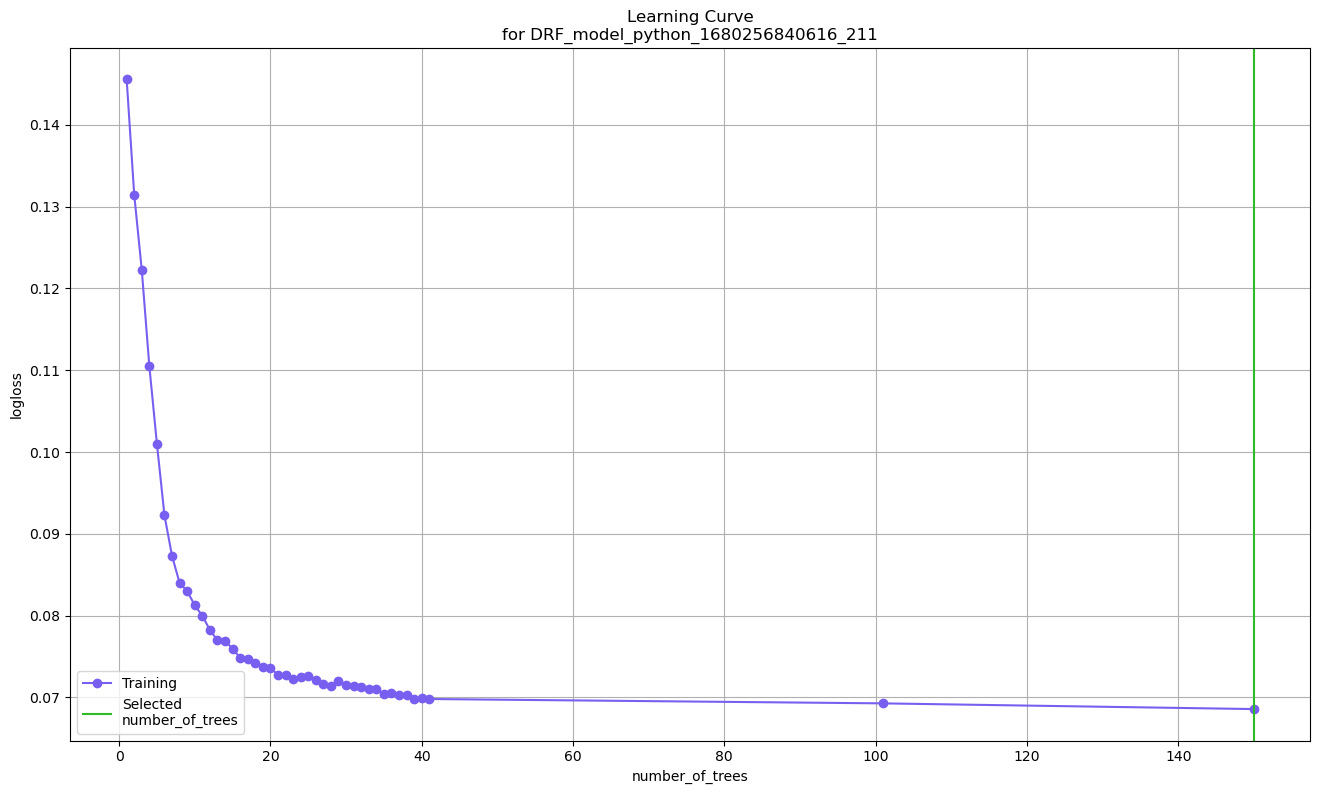

In [28]:
rf_2model.learning_curve_plot()

In [33]:
rf_3model = H2ORandomForestEstimator(seed=1,mtries=3,max_depth=15,ntrees=100,histogram_type='Random')
rf_3model.train(x=predictors, y=response, training_frame=train_h2o)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1680256840616_441


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         920646                 15           15           15            254           1385          726.72

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.017223142490170724
RMSE: 0.1312369707444161
LogLoss: 0.07906734934360947
Mean Per-Class Error: 0.04805870152344926
AUC: 0.9847752409779693
AUCPR: 0.9633830374600646
Gini: 0.9695504819559386

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17775036469054584
       0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      194116  523    0.0027   (523.0/194639.0)
1      2439    23666  0.0934   (2439.0/26105.0)
Total  196555  24189  0.0134   (2962.0/220744.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.17775      0.941106  241
max f2                       0.110746     0.92642   262
max f0point5                 0.297499     0.966605  213
max accuracy                 0.17775      0.986582  241
max precision                0.999973     1         0
max recall                   0.0129979    1         380
max specificity              0.999973     1         0
max absolute_mcc             0.17775      0.934411  241
max min_per_class_accuracy   0.0630709    0.948745  294
max mean_per_class_accuracy  0.0980931    0.958498  269
max tns                      0.999973     194639    0
max fns                      0.999973     21189     0
max fps                      0.000672459  194639    399
max tps                      0.0129979    26105     380
max tnr                      0.999973     1         0
max fnr                      0.999973     0.811684  0
max fpr                      0.000672459  1         399
max tpr                      0.0129979    1         380

Gains/Lift Table: Avg response rate: 11.83 %, avg score: 11.79 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0188136                   1                  8.456      8.456              1                1           1                           1                   0.159088        0.159088                   745.6     745.6              0.159088
2        0.0200323                   0.999937           8.456      8.456              1                0.999944    1                           0.999997            0.0103045       0.169393                   745.6     745.6              0.169393
3        0.0300031                   0.990242           8.456      8.456              1                0.997248    1                           0.999083            0.0843133       0.253706                   745.6     745.6              0.253706
4        0.0400011                   0.97199            8.456      8.456              1                0.97978     1                           0.994258            0.0845432       0.338249                   745.6     745.6              0.338249
5        0.0500036                   0.954579           8.456      8.456              1                0.96414

In [35]:
rf_3model.model_performance(validation_h2o)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.010869869336460194
RMSE: 0.10425866552215309
LogLoss: 0.06270051806376054
Mean Per-Class Error: 0.08321662204917754
AUC: 0.9899913933708621
AUCPR: 0.9168687082576839
Gini: 0.9799827867417241

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49762779177502836
       0      1     Error    Rate
-----  -----  ----  -------  -----------------
0      95334  464   0.0048   (464.0/95798.0)
1      679    3523  0.1616   (679.0/4202.0)
Total  96013  3987  0.0114   (1143.0/100000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497628     0.860423  121
max f2                       0.415573     0.857815  138
max f0point5                 0.795936     0.900568  64
max accuracy                 0.497628     0.98857   121
max precision                0.952743     0.998803  16
max recall                   0.0263027    1         351
max specificity              0.998696     0.99999   0
max absolute_mcc             0.497628     0.854788  121
max min_per_class_accuracy   0.105981     0.951669  245
max mean_per_class_accuracy  0.103716     0.952007  247
max tns                      0.998696     95797     0
max fns                      0.998696     4202      0
max fps                      0.00198726   95798     399
max tps                      0.0263027    4202      351
max tnr                      0.998696     0.99999   0
max fnr                      0.998696     1         0
max fpr                      0.00198726   1         399
max tpr                      0.0263027    1         351

Gains/Lift Table: Avg response rate:  4.20 %, avg score:  7.43 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.962696           23.7506     23.7506            0.998            0.969126   0.998                       0.969126            0.237506        0.237506                   2275.06   2275.06            0.237485
2        0.02                        0.943339           23.7744     23.7625            0.999            0.954623   0.9985                      0.961875            0.237744        0.47525                    2277.44   2276.25            0.475219
3        0.03                        0.81275            21.5374     23.0208            0.905            0.890645   0.967333                    0.938132            0.215374        0.690624                   2053.74   2202.08            0.689601
4        0.04                        0.492526           14.8977     20.99              0.626            0.652737   0.882                       0.866783            0.148977        0.8396                     1389.77   1999               0.834673
5        0.05                        0.282032           4.52166     17.6963            0.19             0.364963   0.7436                      0.766419            0.0452166       0.884817                   352.166   1669.63            0.871434
6        0.1                         0.0913986          1.5564      9.62637            0.0654           0.146695   0.4045                      0.456557            0.0778201       0.962637                   55.6402   862.637            0.900475
7        0.15                        0.0653466          0.409329    6.55402            0.0172           0.0763117  0.2754                      0.329809            0.0204664       0.983103                   -59.0671  555.402            0.869

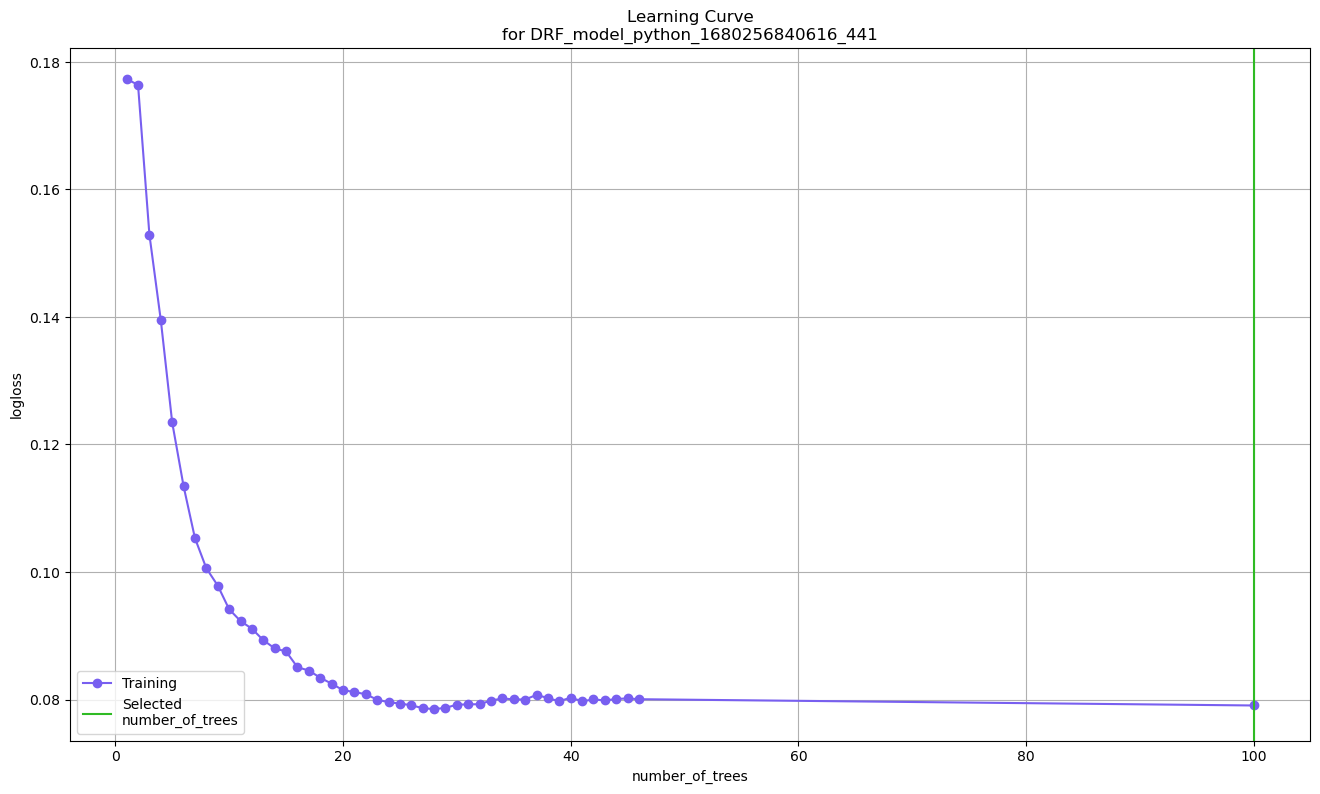

In [36]:
rf_3model.learning_curve_plot()

In [37]:
rf_4model = H2ORandomForestEstimator(seed=1,mtries=3,max_depth=15,ntrees=50,histogram_type='Random')
rf_4model.train(x=predictors, y=response, training_frame=train_h2o)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1680256840616_491


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          472123                 15           15           15            254           1385          745.46

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.017505605640559002
RMSE: 0.1323087511866052
LogLoss: 0.08028558473349331
Mean Per-Class Error: 0.0509734941958894
AUC: 0.9811273599286645
AUCPR: 0.9580454776260502
Gini: 0.962254719857329

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19283058598703115
       0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      194055  584    0.003    (584.0/194639.0)
1      2583    23522  0.0989   (2583.0/26105.0)
Total  196638  24106  0.0143   (3167.0/220744.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.192831     0.936926  228
max f2                       0.124288     0.921968  251
max f0point5                 0.339077     0.964727  195
max accuracy                 0.200658     0.985676  226
max precision                0.999989     1         0
max recall                   0.0118797    1         381
max specificity              0.999989     1         0
max absolute_mcc             0.200658     0.929874  226
max min_per_class_accuracy   0.064651     0.943651  291
max mean_per_class_accuracy  0.111011     0.95547   257
max tns                      0.999989     194639    0
max fns                      0.999989     19609     0
max fps                      0.000447754  194639    399
max tps                      0.0118797    26105     381
max tnr                      0.999989     1         0
max fnr                      0.999989     0.751159  0
max fpr                      0.000447754  1         399
max tpr                      0.0118797    1         381

Gains/Lift Table: Avg response rate: 11.83 %, avg score: 11.79 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0274843                   1                  8.456      8.456              1                1           1                           1                   0.232408        0.232408                   745.6     745.6              0.232408
2        0.0301027                   0.999584           8.456      8.456              1                0.999805    1                           0.999983            0.0221414       0.254549                   745.6     745.6              0.254549
3        0.0400011                   0.97882            8.456      8.456              1                0.9917      1                           0.997933            0.0837004       0.338249                   745.6     745.6              0.338249
4        0.0500036                   0.949645           8.456      8.456              1                0.961978    1                           0.990741            0.0845815       0.422831                   745.6     745.6              0.422831
5        0.100003                    0.456835           8.39318    8.42459            0.99257          0.802456 

In [40]:
rf_4model.model_performance(validation_h2o)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.010749700438463487
RMSE: 0.10368076214256668
LogLoss: 0.06250668514959247
Mean Per-Class Error: 0.07635168177081796
AUC: 0.9890371839746609
AUCPR: 0.9135610684081078
Gini: 0.9780743679493218

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4670059429746205
       0      1     Error    Rate
-----  -----  ----  -------  -----------------
0      95327  471   0.0049   (471.0/95798.0)
1      621    3581  0.1478   (621.0/4202.0)
Total  95948  4052  0.0109   (1092.0/100000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467006     0.867701  126
max f2                       0.376976     0.863042  147
max f0point5                 0.815979     0.913467  59
max accuracy                 0.467006     0.98908   126
max precision                0.933689     0.994018  24
max recall                   0.0213527    1         361
max specificity              0.999412     0.999979  0
max absolute_mcc             0.467006     0.862162  126
max min_per_class_accuracy   0.111071     0.952139  242
max mean_per_class_accuracy  0.111071     0.953223  242
max tns                      0.999412     95796     0
max fns                      0.999412     4202      0
max fps                      0.00155195   95798     399
max tps                      0.0213527    4202      361
max tnr                      0.999412     0.999979  0
max fnr                      0.999412     1         0
max fpr                      0.00155195   1         399
max tpr                      0.0213527    1         361

Gains/Lift Table: Avg response rate:  4.20 %, avg score:  7.36 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.952025           23.5602     23.5602            0.99             0.960275    0.99                        0.960275            0.235602        0.235602                   2256.02   2256.02            0.235498
2        0.02                        0.92536            23.7268     23.6435            0.997            0.939172    0.9935                      0.949724            0.237268        0.47287                    2272.68   2264.35            0.472734
3        0.03002                     0.826344           23.0144     23.4335            0.967066         0.885369    0.984677                    0.928244            0.230604        0.703475                   2201.44   2243.35            0.702994
4        0.04                        0.479197           14.2598     21.1447            0.599198         0.65114     0.8885                      0.859107            0.142313        0.845788                   1325.98   2014.47            0.841132
5        0.05                        0.294932           3.68872     17.6535            0.155            0.373708    0.7418                      0.762027            0.0368872       0.882675                   268.872   1665.35            0.869199
6        0.1                         0.0928536          1.61828     9.63589            0.068            0.152232    0.4049                      0.45713             0.0809139       0.963589                   61.8277   863.589            0.901468
7        0.15                        0.0651489          0.385531    6.55244            0.0162           0.0767009   0.275333                    0.33032             0.0192765       0.982865                   -61.4469  555.244         

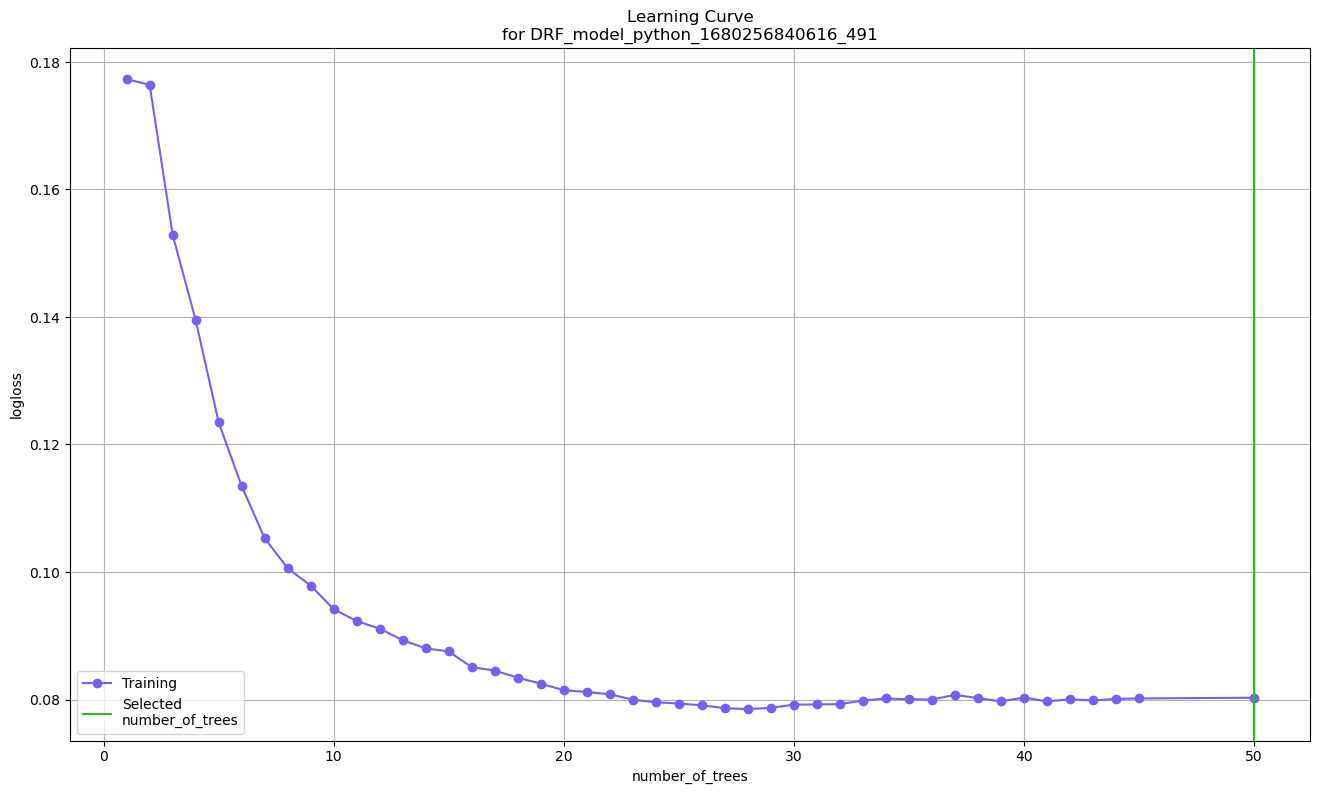

In [41]:
rf_4model.learning_curve_plot()

In [43]:
rf_4model.model_performance(test)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.08607764751628483
RMSE: 0.29338992401969916
LogLoss: 0.2850543542126062
Mean Per-Class Error: 0.13789716372509686
AUC: 0.9149414130727681
AUCPR: 0.7308461869304076
Gini: 0.8298828261455362

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18633682950984531
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      235455  30202  0.1137   (30202.0/265657.0)
1      9503    49119  0.1621   (9503.0/58622.0)
Total  244958  79321  0.1224   (39705.0/324279.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.186337     0.712164  266
max f2                       0.122874     0.79482   292
max f0point5                 0.806683     0.676829  71
max accuracy                 0.250667     0.879502  245
max precision                0.981703     0.981667  5
max recall                   0.00699958   1         397
max specificity              0.999939     0.999721  0
max absolute_mcc             0.172583     0.648893  270
max min_per_class_accuracy   0.14104      0.867476  283
max mean_per_class_accuracy  0.143675     0.868172  282
max tns                      0.999939     265583    0
max fns                      0.999939     55934     0
max fps                      0.0024483    265657    399
max tps                      0.00699958   58622     397
max tnr                      0.999939     0.999721  0
max fnr                      0.999939     0.954147  0
max fpr                      0.0024483    1         399
max tpr                      0.00699958   1         397

Gains/Lift Table: Avg response rate: 18.08 %, avg score: 19.12 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100006                   0.993234           5.40376    5.40376            0.976873         0.999438   0.976873                    0.999438            0.0540411       0.0540411                  440.376   440.376            0.0537588
2        0.0200013                   0.963238           4.91081    5.15729            0.887758         0.974978   0.932316                    0.987208            0.0491113       0.103152                   391.081   415.729            0.1015
3        0.0300019                   0.956578           4.85281    5.05579            0.877274         0.960017   0.913969                    0.978144            0.0485313       0.151684                   385.281   405.579            0.148533
4        0.0400519                   0.940141           4.92574    5.02316            0.890457         0.948559   0.908069                    0.970721            0.0495036       0.201187                   392.574   402.316            0.196693
5        0.0500002                   0.927196           4.66405    4.95171            0.843149         0.934751   0.895152                    0.963564            0.046399        0.247586                   366.405   395.171            0.241187
6        0.1                         0.765127           3.65698    4.30434            0.661095         0.858299   0.778124                    0.910931            0.182849        0.430436                   265.698   330.434            0.403352
7        0.15                        0.549744           2.46391    3.69087            0.445418         0.666732   0.667222                    0.829531            0.123196        0.553632                   146.391   269.087            0

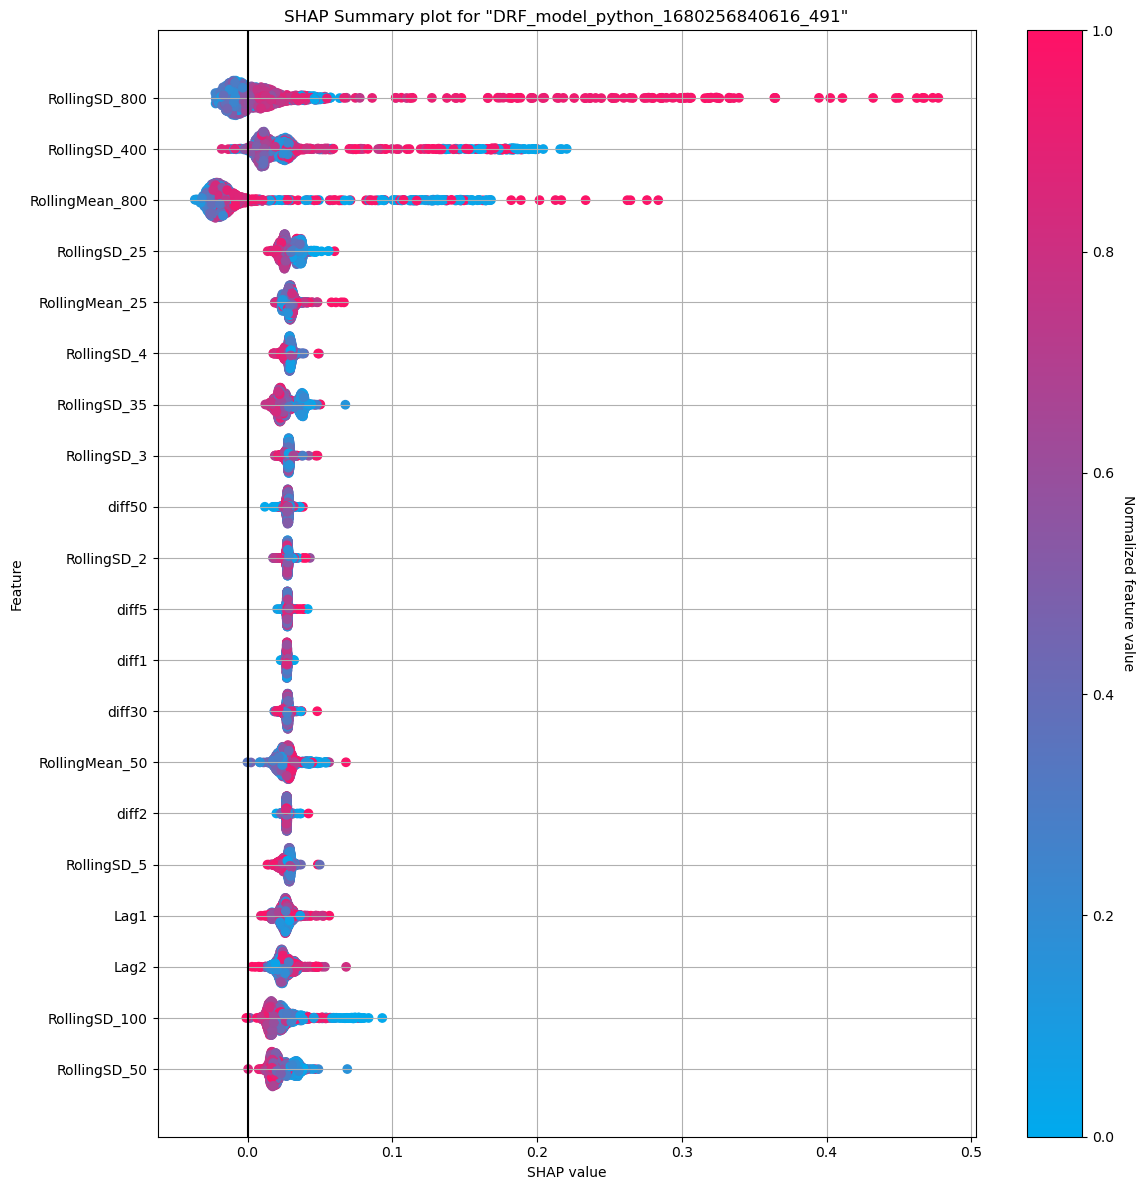

In [44]:
rf_4model.shap_summary_plot(test)

In [46]:
rf_4model.varimp()

[('RollingMean_400', 85204.4375, 1.0, 0.14312479017508348),
 ('RollingMean_800', 84269.3125, 0.9890249260785273, 0.1415539850229167),
 ('RollingSD_800', 77863.6796875, 0.9138453579662444, 0.1307939251113928),
 ('RollingMean_200', 59378.46875, 0.6968940878225973, 0.09974282009386544),
 ('RollingSD_400', 50173.265625, 0.5888574245326131, 0.0842800953292703),
 ('RollingSD_200', 31352.2578125, 0.3679650817775776, 0.05266492512117323),
 ('RollingMean_100',
  17826.767578125,
  0.20922346419017201,
  0.029945064411922465),
 ('RollingSD_100',
  16165.5419921875,
  0.18972652676907234,
  0.027154569334470836),
 ('meanaddsd', 14138.111328125, 0.16593163153180843, 0.023748929946399346),
 ('Lag50', 10032.2060546875, 0.11774276491981418, 0.016851908523782586),
 ('RollingMean_50', 9354.158203125, 0.10978487127651068, 0.015712936665849143),
 ('Lag10', 9168.6162109375, 0.1076072617806731, 0.015401266763674119),
 ('RollingSD_25', 9146.203125, 0.10734421109229199, 0.015363617689094161),
 ('Lag30', 8775

In [49]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

predictions = rf_4model.predict(test)
fixed_threshold = 0.19283058598703115 #treshhold of training
predictions['prediction'] = (predictions['p1'] >= fixed_threshold).ifelse(1, 0)
y_true = test.as_data_frame()['Anomaly'].values
y_pred = predictions.as_data_frame()['prediction'].values
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print('prec:',precision,'recall:',recall,'f1:',f1)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
prec: 0.6214539571736112 recall: 0.8322131622940193 f1: 0.7115551504102096
